# Tweets related to citizenship S2. 22/2/2018 - 02/3/2018

The following will analyse a preprocessed dataset of around `65,000` tweets collected between `22/2/2018` - `02/3/2018`. These have been sourced using twitters `streaming API`, the query terms were as follows:

**Terms Tracked:** `'citizen'`, `'citizenship'`.

Though perhaps quite naive use tracking terms, they were chosen as a way to get an intial guage of the kinds of discussions that are linked with citizenship on twitter and serve as a starting point for further possible investigations.

In [3]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from IPython.core.display import HTML
from IPython.core.display import display

plt.style.use('ggplot')

df = pd.read_csv("../data/tweets_large_train", na_filter=False)
df.time = pd.to_datetime(df.time, format="%d/%m/%Y %H:%M:%S")
df = df.sort_values(by='time').set_index('time')

In [4]:
display(df.head(3))
print(df.dtypes)
print("\nNumber of (rows, cols):", df.shape)

,text,polarity,subjectivity,tags,tag_count,mentioned,mentioned_count
time,,,,,,,
2018-02-21 23:12:57,post post bitch censorship right nobodi stop r...,0.2286,0.4619,,0,ScottPresler Boyd_2650,2
2018-02-21 23:13:00,wait law abid citizen own gun taken away ever ...,-0.2333,0.6000,,0,MailbornJenkins,1
2018-02-21 23:13:00,watch countri shoot foot take away everyon eu ...,-0.2107,0.3714,,0,pj11nufc JohnRob67389614 SkyNews,3


text                object
polarity           float64
subjectivity       float64
tags                object
tag_count            int64
mentioned           object
mentioned_count      int64
dtype: object

Number of (rows, cols): (65291, 7)


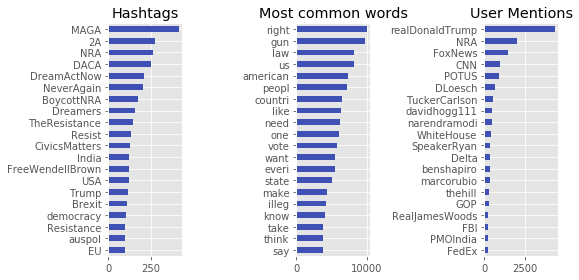

In [5]:
top_n = 20

def plot_counts(col, top_n=top_n, **kwargs):
    c = df[col].str.split(expand=True).stack().value_counts()
    for s in stopwords:
        del c[s]
    c = c[:top_n]
    c.plot(kind="barh", **kwargs).invert_yaxis()
    return c

stopwords = set(["citizen", "citizenship"])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(8, 4)

top_tags = plot_counts("tags", ax=ax1, title="Hashtags", color="#3F51B5")
plot_counts("text", ax=ax2, title="Most common words", color="#3F51B5")
plot_counts("mentioned", ax=ax3, title="User Mentions", color="#3F51B5")

plt.tight_layout()
plt.show()

## Time based plotting

As this second dataset has timestamps we can look over how hashtags and other features have progressed over time.

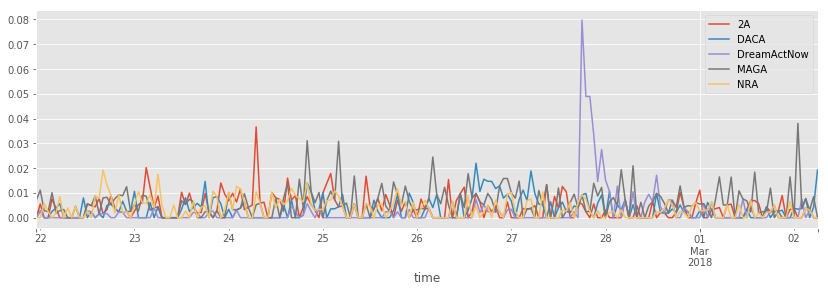

In [6]:
_data = top_tags[:5]

# NOTE: 
#   this isnt working for top words for some
#   reason, can't be asked to work out why.
#   other text data seems to be counting 
#   correctly.
def count_item(item, *args):
    return item.split().count(args[0])

ts = pd.DataFrame(
    index=df.index, 
    data={t: df.tags.apply(count_item, args=(t,)) 
          for t, _ in _data.items()}
).resample('H').mean()

ts.plot(figsize=(14, 4))
plt.show()

### Sentiment Over Time

Sentiment analysis was performed in the preprocessing step using the [TextBlob](https://github.com/sloria/TextBlob) text analysis package. The classifier is trained on movie reviews and claims to have an accuracy of 75% [ref](https://github.com/sloria/TextBlob/blob/dev/textblob/en/en-sentiment.xml). Values/ranges for each are described as follows:

    Subjectivity:  0.0 - 1.0
    Polarity:     -1.0 - 0.0

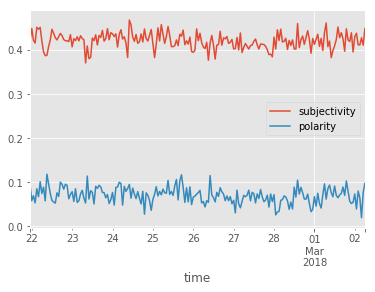

In [7]:
ts = df.resample('H').mean()
ts.plot(y=["subjectivity", "polarity"])
plt.show()

Just plotting against time, neither `subjectivity` or `polarity` show any obvious events across the dataset. Even when samoling shorter time periods, no notable patterns are found. 

## Profanity levels

does profanity within text show us something?

In [25]:
with open("../utils/badwords.txt") as f:
    badwords = set([w.lower() 
                    for w in f.read().split("\n") 
                    if " " not in w and len(w) > 2])

In [26]:
def count_bad(tweet):
    return int(any(((b in tweet) for b in badwords)))

bad_tweets = df.text.apply(count_bad).sum()
print(bad_tweets)
print("tweets containing profanity: {:.2f}%".format(bad_tweets / len(df) * 100))

17342
tweets containing profanity: 26.56%


## Ngram frequencies

We can see how often sequences of words appear together in the data providing slightly more description that just counting word occurance. 

In [7]:
def plot_ngrams(n0, n1, n_features=1000, filter_fn=None):
    z = n1 - n0
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 5)
    for i in range(z):
        tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                     max_features=n_features,
                                     ngram_range=(n0 + i, n0 + i + 1))
        tfidf_features = tfidf_vect.fit_transform(df.text)
        vocab = tfidf_vect.get_feature_names()
        values = tfidf_features.toarray().sum(axis=0)
        if filter_fn:
            sample = [(values[i], k) for i, k in enumerate(vocab) if filter_fn(k)]
        else:
            sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:20])
        dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
        dd.plot(kind="barh", ax=axis[i], color="#3F51B5", legend=False).invert_yaxis()
    plt.tight_layout()
    plt.show()


def word_end(word): 
    def f(k): 
        return k.endswith(word)
    return f

def word_start(word): 
    def f(k): 
        return k.startswith(word)
    return f

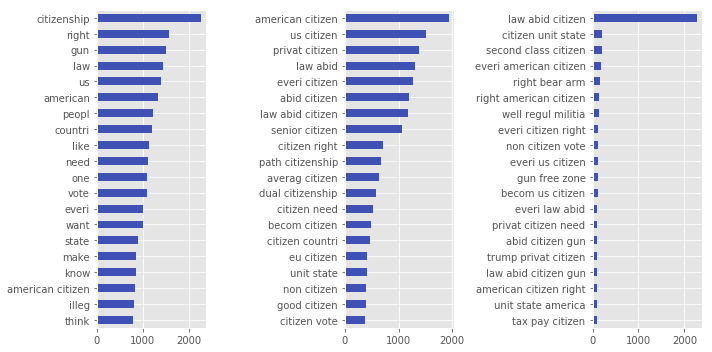

In [9]:
plot_ngrams(1, 4)

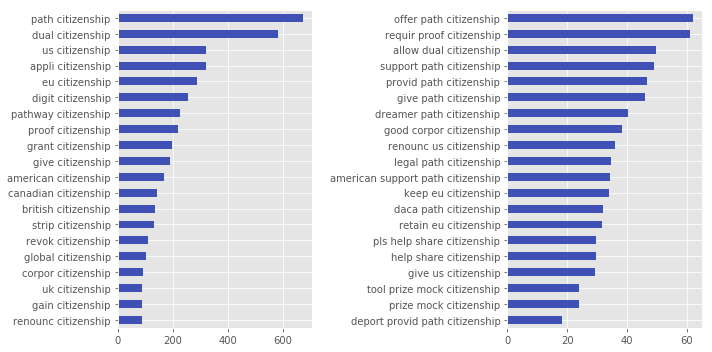

In [10]:
plot_ngrams(2, 4, filter_fn=word_end("citizenship"))

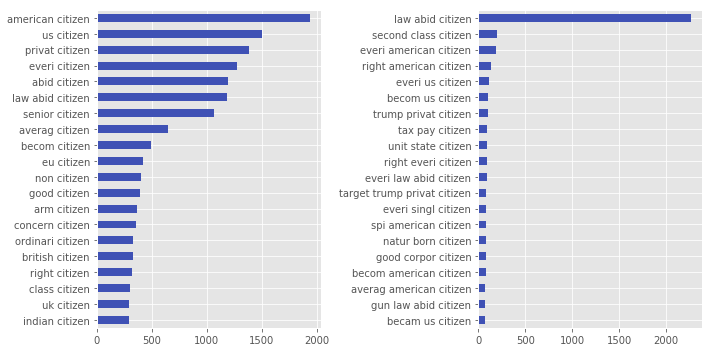

In [11]:
plot_ngrams(2, 4, filter_fn=word_end("citizen"))

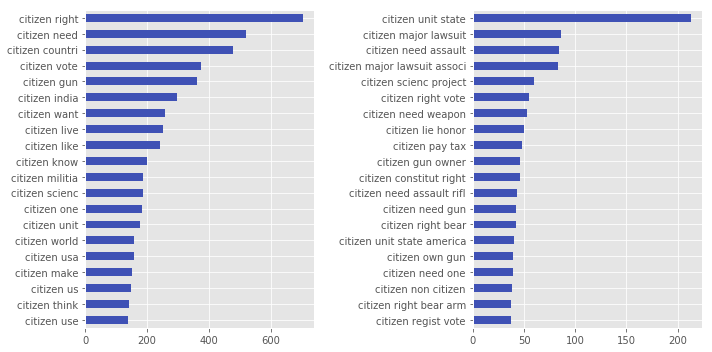

In [12]:
plot_ngrams(2, 4, filter_fn=word_start("citizen "))

## Topic & Feature Extraction

As a starting point we can use hashtags, user mentions and most common words in the tweets to discern some overarching themes within the tweets. I'm not sure what method can be used to find how episodic the content is, but presume that it will have something to do with Tf-idf. 

https://pdfs.semanticscholar.org/5b5c/a878c534aee3882a038ef9e82f46e102131b.pdf
http://text-analytics101.rxnlp.com/2015/11/understanding-text-similarity.html

In [17]:
n_features = 5000
n_topics = 5
n_samples = 40

def print_top_words(model, feature_names, n_top_words):
    ol = [", ".join([feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]])
         for topic_idx, topic in enumerate(model.components_)]
    display(HTML("<ol><li>{}</li></ol>".format("</li><li>".join(ol))))

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, 
                                   max_features=n_features,
                                   ngram_range=(1,3))

tfidf_features = tfidf_vectorizer.fit_transform(df.text.astype(str))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [19]:
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features,\nnumber of topics=%d\nn_samples=%d and n_features=%d..." 
      % (n_topics, n_samples, n_features))

t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=10000, alpha=.1, l1_ratio=.5).fit(tfidf_features)
print("time: {:.2f} secs".format(time.time() - t0))

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features,
number of topics=5
n_samples=40 and n_features=5000...
time: 25.17 secs


In [24]:
display(HTML("<h3>Topics Generated by NMF Model</h3>"))
print_top_words(nmf, tfidf_feature_names, n_samples)

# NMF model qualitative sumary

1. General sentiments about global citizenship.
2. ??? Maybe Lawsuit against trump, trying him as public citizen. Maybe -> https://www.washingtonpost.com/politics/arguments-begin-in-emoluments-suit-against-trump/2018/01/25/c73809de-015a-11e8-9d31-d72cf78dbeee_story.html?utm_term=.993960fe498c ??? Maybe -> https://twitter.com/realDonaldTrump/status/968924154031497226
3. US gun control: rights and responsibilities of citizens, eg abiding laws, stopping criminals.
4. Us gun control: relations to assult wepons, second ammendment, nra.
5. citizens rights voting etc.

In [16]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tf_features = tf_vectorizer.fit_transform(df.text)
tf_feature_names = tf_vectorizer.get_feature_names()
print('Number of unique words:', len(tf_feature_names))

Number of unique words: 5000


In [17]:
print("Fitting LDA models with tf features, "
      "\nnumber of topics=%d\nn_samples=%d and n_features=%d..."
      % (n_topics, n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time.time()
lda.fit(tf_features)
print("time: {:.2f} secs".format(time.time() - t0))

Fitting LDA models with tf features, 
number of topics=5
n_samples=30 and n_features=5000...
time: 655.36 secs


In [46]:
display(HTML("<h3>Topics Generated by LDA model</h3>"))
print_top_words(lda, tf_feature_names, n_samples*2)

# LDA model qualitative sumary

1. DACA.
2. Money, labour, trade, citizens
3. Gun rights.
4. Citizenship/membership to nation states.
5. fbi investigation into private citizen ???

## Categorising data based on our generated models

**TODO:** This section is all broken fix this at one point (maybe)

In [30]:
# x = lda.transform(df.text)

In [79]:
print(np.argmax(x, axis=1))

[3 1 1 ..., 4 0 4]


In [61]:
ind = np.unravel_index(np.argmax(x), x.shape)
print(ind)

(23476, 0)


In [73]:
len(np.argmax(x, axis=1))

65291

In [75]:
print(tf_features)
tf_feature_names[]

  (0, 583)	1
  (0, 1190)	1
  (0, 1953)	1
  (0, 1419)	1
  (0, 1644)	1
  (0, 273)	1
  (0, 1403)	1
  (0, 2807)	1
  (0, 2057)	1
  (0, 2851)	2
  (0, 440)	1
  (0, 2574)	1
  (0, 1186)	1
  (0, 2620)	1
  (0, 1874)	1
  (0, 2334)	2
  (0, 295)	1
  (0, 2097)	2


In [27]:
tf_feature_names[583]

'bright'